

Download dataset from kaggle

In [1]:
!kaggle datasets download -d shravankumar9892/image-colorization


  0%|          | 0.00/2.10G [00:00<?, ?B/s]
  0%|          | 1.00M/2.10G [00:00<13:36, 2.77MB/s]
  0%|          | 2.00M/2.10G [00:00<11:59, 3.14MB/s]
  0%|          | 3.00M/2.10G [00:01<12:18, 3.06MB/s]
  0%|          | 4.00M/2.10G [00:01<11:55, 3.15MB/s]
  0%|          | 5.00M/2.10G [00:01<11:37, 3.23MB/s]
  0%|          | 6.00M/2.10G [00:01<10:36, 3.54MB/s]
  0%|          | 7.00M/2.10G [00:02<10:15, 3.66MB/s]
  0%|          | 8.00M/2.10G [00:02<09:33, 3.93MB/s]
  0%|          | 9.00M/2.10G [00:02<09:28, 3.96MB/s]
  0%|          | 10.0M/2.10G [00:02<09:42, 3.86MB/s]
  1%|          | 11.0M/2.10G [00:03<09:31, 3.94MB/s]
  1%|          | 12.0M/2.10G [00:03<09:23, 3.99MB/s]
  1%|          | 13.0M/2.10G [00:03<09:27, 3.96MB/s]
  1%|          | 14.0M/2.10G [00:03<09:20, 4.01MB/s]
  1%|          | 15.0M/2.10G [00:04<09:09, 4.08MB/s]
  1%|          | 16.0M/2.10G [00:04<09:07, 4.10MB/s]
  1%|          | 17.0M/2.10G [00:04<09:08, 4.09MB/s]
  1%|          | 18.0M/2.10G [00:04<09:08, 4.08MB/s]
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import random
import cv2
import torch.nn as nn
import torch
from tqdm import tqdm

from skimage.color import lab2rgb
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
# from tensorflow.keras.layers import Conv2D,InputLayer, Conv2DTranspose, Dropout, BatchNormalization, Input, Concatenate, Activation, concatenate ,RepeatVector ,Reshape ,UpSampling2D

Extract dataset and load data

In [ ]:
with zipfile.ZipFile("image-colorization.zip", "r") as zip_ref:
    zip_ref.extractall()

In [24]:
AB1 = np.load("ab/ab/ab1.npy")
AB2 = np.load("ab/ab/ab2.npy")
AB3 = np.load("ab/ab/ab3.npy")
L = np.load("l\gray_scale.npy")

Get familiar with the dataset

In [25]:
print(type(L))
print(type(AB1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
print(L.shape)    #25k 224x224 grayscale images
print(AB1.shape)
print(AB2.shape)
print(AB3.shape)

(25000, 224, 224)
(10000, 224, 224, 2)
(10000, 224, 224, 2)
(5000, 224, 224, 2)


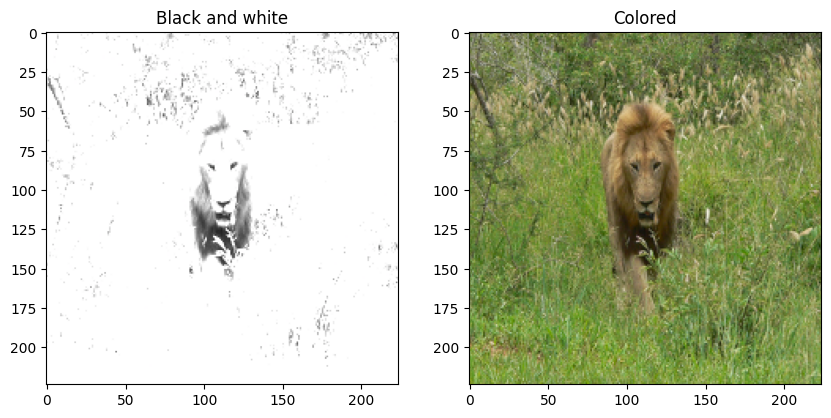

In [5]:
i = random.randint(0, AB1.shape[0]-1)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
img = np.zeros((224,224,3))
img[:,:,0] = L[i]
plt.title('Black and white')
plt.imshow(lab2rgb(img))

plt.subplot(1,2,2)
img[:,:,1:] = AB1[i]
img = img.astype('uint8')
img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
plt.title('Colored')
plt.imshow(img)


Split data between train, validation, test

In [27]:
num_samples = AB3.shape[0]
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

In [28]:
#Variables used for splitting
L = np.expand_dims(L, -1)
L = L[len(AB1) + len(AB2):]
print(L.shape)

(5000, 224, 224, 1)


In [29]:
#Calculate sizes of each set

num_train_samples = int(num_samples * train_frac)
num_val_samples = int(num_samples * val_frac)
num_test_samples = int(num_samples * test_frac)

In [30]:
#Shuffle indices

indices = np.random.RandomState(seed=23419).permutation(num_samples)

In [31]:
#Split indices

train_indices = indices[:num_train_samples]
val_indices = indices[num_train_samples:num_train_samples+num_val_samples]
test_indices = indices[num_train_samples+num_val_samples:]

In [32]:
X_train = L[train_indices]
y_train = AB3[train_indices]

X_val = L[val_indices]
y_val = AB3[val_indices]

X_test = L[test_indices]
y_test = AB3[test_indices]

In [33]:
X_train = X_train.transpose((0,3,1,2))
y_train = y_train.transpose((0,3,1,2))

X_val = X_val.transpose((0,3,1,2))
y_val = y_val.transpose((0,3,1,2))

X_test = X_test.transpose((0,3,1,2))
y_test= y_test.transpose((0,3,1,2))

In [34]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

X_val = X_val.astype('float32')
y_val = y_val.astype('float32')

X_test = X_test.astype('float32')
y_test= y_test.astype('float32')

In [35]:
print("Train")
print(X_train.shape)
print(y_train.shape)

print("\nValidation")
print(X_val.shape)
print(y_val.shape)

print("\nTest")
print(X_test.shape)
print(y_test.shape)

Train
(4000, 1, 224, 224)
(4000, 2, 224, 224)

Validation
(500, 1, 224, 224)
(500, 2, 224, 224)

Test
(500, 1, 224, 224)
(500, 2, 224, 224)


Dataset

In [36]:
class ImageDataset(Dataset):
    def __init__(self, ls, abs, transform=None):
        self.ls = ls
        self.abs = abs
        self.transform = transform
        
    def __len__(self):
        return len(self.ls)
    
    def __getitem__(self, idx):
        l = self.ls[idx]
        ab = self.abs[idx]
        
        if self.transform:
            l = l.transform(l)
            ab = self.transform(ab)
            
        return l, ab

Network architecture

In [37]:
from torchvision import models

class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

Use GPU

In [38]:
import os
import tensorflow as tf

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on " + device.type)


Running on cuda


In [46]:
import torch.optim as optim

epochs = 5
net = ColorizationNet()
net = net.to(device)

net_optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0)

net_optimizer.zero_grad()

loss_fn = nn.MSELoss()

In [47]:
train_dataset = ImageDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4)

val_dataset = ImageDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=4)

In [48]:
path = "./model/model_300.pth"
checkpoint = torch.load(path)
net.load_state_dict(checkpoint['model_state_dict'])
net_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
saved_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [49]:
def train_fn(epochs: int, train_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
  
  net.to(device)
  # Iteram prin numarul de epoci
  for e in range(saved_epoch, saved_epoch + epochs):
    net.train()
    # Iteram prin fiecare batch din dataloader
    epoch_loss = 0
    for images, labels in tqdm(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe etichetele imaginilor 
      loss = loss_fn(out, labels)
      # Aplicam algoritmul de back-propagation
      loss.backward()
      epoch_loss += loss.item()
      # Facem pasul de optimizare, pentru a actualiza parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()
    with torch.no_grad():
      epoch_val_loss = 0
      for (images, labels) in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        out = net(images)
        loss = loss_fn(out, labels)
        epoch_val_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    print(f"Epoch: {e}, train loss: {avg_loss}, validation loss: {avg_val_loss}")
    torch.save({
            'epoch': e,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'./model/model_{e}.pth')
      


torch.Size([2, 224, 224])
tensor([[[132., 130., 127.,  ..., 126., 127., 126.],
         [123., 125., 128.,  ..., 131., 130., 132.],
         [125., 128., 125.,  ..., 127., 127., 127.],
         ...,
         [126., 124., 126.,  ..., 123., 127., 129.],
         [125., 124., 125.,  ..., 121., 126., 128.],
         [126., 124., 125.,  ..., 124., 127., 126.]],

        [[115., 119., 121.,  ..., 122., 119., 119.],
         [120., 120., 117.,  ..., 119., 121., 117.],
         [120., 118., 121.,  ..., 122., 121., 118.],
         ...,
         [129., 132., 131.,  ..., 129., 129., 133.],
         [129., 133., 133.,  ..., 129., 133., 135.],
         [128., 133., 133.,  ..., 128., 132., 138.]]])
tensor([[[125.3222, 125.3222, 122.3843,  ..., 122.2067, 126.8342, 126.8342],
         [125.3222, 125.3222, 122.3843,  ..., 122.2067, 126.8342, 126.8342],
         [127.2630, 127.2630, 123.0235,  ..., 124.6845, 128.5000, 128.5000],
         ...,
         [126.0173, 126.0173, 125.2496,  ..., 121.3504, 126.6

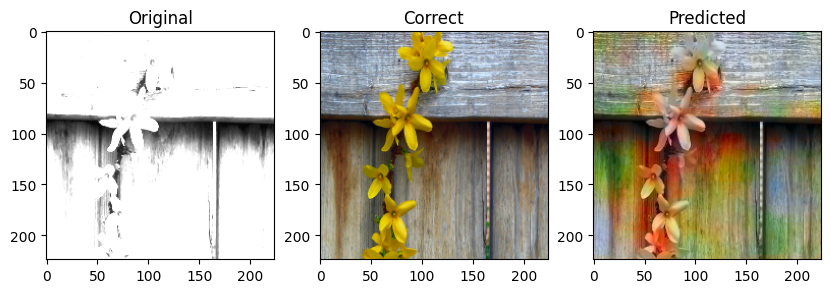

In [50]:
test_dataset = ImageDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1)

r = random.randint(0,370)
iterable = iter(test_loader)
for i in range(r):
    grayscale, correct = next(iterable)
grayscale = grayscale.to(device)
predicted = net(grayscale)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
img = np.zeros((224,224,3))

img[:,:,0] = grayscale[0].cpu().numpy()[0]
plt.title('Original')
plt.imshow(lab2rgb(img))
plt.subplot(1,3,2)
print(correct[0].shape)
img[:,:,1:] = correct[0].cpu().numpy().transpose((1,2,0))
img = img.astype('uint8')
img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
plt.title('Correct')

plt.imshow(img)
print(correct[0])
print(predicted[0])
plt.subplot(1,3,3)
img = np.zeros((224,224,3))
img[:,:,0] = grayscale[0].cpu().numpy()[0]
img[:,:,1:] = predicted[0].cpu().detach().numpy().transpose((1,2,0))
img = img.astype('uint8') 
img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
plt.title('Predicted')
plt.imshow(img)
plt.show()

In [51]:
train_fn(epochs=epochs, train_loader=train_loader, net=net, loss_fn=loss_fn, optimizer=net_optimizer)

100%|██████████| 125/125 [00:04<00:00, 29.08it/s]


Epoch: 300, train loss: 302.7963986206055, validation loss: 303.345210357666


100%|██████████| 125/125 [00:05<00:00, 24.69it/s]


Epoch: 301, train loss: 288.64582077789305, validation loss: 305.6390149230957


100%|██████████| 125/125 [00:04<00:00, 29.88it/s]


Epoch: 302, train loss: 275.4591501197815, validation loss: 311.2546809082031


 13%|█▎        | 126/1000 [00:12<01:26, 10.13it/s]


KeyboardInterrupt: 